# LXMERT project
GD 노드 20

프로세스는 다음과 같다.
1. 다른 이미지 테스트해보기
2. GQA 데이터셋 버전 모델 테스트해 보기
3. 내가 선택한 이미지로 VQA/GQA 버전 비교해 보기

## STEP 1. 다른 이미지 테스트해 보기
앞서 실습해 본 LXMERT 모델 활용법을 다른 이미지를 통해서도 한번 시도하고 결과를 확인해 봅시다.

### 데이터 로드
모델을 활용하기 위해서 데이터를 불러온다.

In [1]:
# 오늘 실습을 위한 작업디렉토리로 이동합니다.
!cd ~/aiffel/lxmert

from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
import wget
import pickle
import os, sys

# 추가해준 모듈을 임포트하기 위해 아래 경로를 path에 추가합니다. 
sys.path.append(os.getenv('HOME')+'/aiffel/lxmert')
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils

print(torch.__version__)

Duplicate key in file PosixPath('/home/aiffel-dj28/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family:  NanumGothic')


1.8.1+cu102


In [2]:
# object definition
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
objids = utils.get_data(OBJ_URL)
print(len(objids))
print(objids[:30])  #1600개의 단어사전 중 30개만 출력

1600
['yolk', 'goal', 'bathroom', 'macaroni', 'umpire', 'toothpick', 'alarm clock', 'ceiling fan', 'photos', 'parrot', 'tail fin', 'birthday cake', 'calculator', 'catcher', 'toilet', 'batter', 'stop sign,stopsign', 'cone', 'microwave,microwave oven', 'skateboard ramp', 'tea', 'dugout', 'products', 'halter', 'kettle', 'kitchen', 'refrigerator,fridge', 'ostrich', 'bathtub', 'blinds']


In [3]:
# attribute definition
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
attrids = utils.get_data(ATTR_URL)
print(len(attrids))
print(attrids[:30])   #400개의 단어사전 중 30개만 출력

400
['gray,grey', 'multi colored,multi-colored,multicolored', 'double decker,double-decker', 'unmade', 'red', 'camouflage', 'blue', 'white', 'green', 'pink', 'yellow', 'black', 'ivory', 'throwing', 'orange', 'spiky', 'plaid', 'purple', 'soccer', 'brake', 'blonde', 'american', 'flat screen', 'brown', 'wooden', 'performing', 'pulled back', 'windshield', 'bald', 'chocolate']


In [4]:
# VQA answer definition
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
vqa_answers = utils.get_data(VQA_URL)
print(len(vqa_answers))
print(vqa_answers[:30])  #3129개의 단어사전 중 30개만 출력

3129
['', 'woods', 'trash can', 'hanging', 'wooden', 'cooking', 'china', 'kids', 'bike rack', 'on phone', 'music', 'travel', 'tulip', 'arrow', 'branch', 'chevron', 'mouth', 'on right', 'rice', 'plate', 'lots', 'nature', 'fruits', 'throwing frisbee', 'blonde', 'life jacket', 'ham', 'hay', 'hat', 'to get to other side']


In [5]:
# image
URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
image_preprocess = Preprocess(frcnn_cfg)

images, sizes, scales_yx = image_preprocess(URL)

loading configuration file cache


In [6]:
print(images)
print(sizes)

tensor([[[[  61.0199,   61.2689,   62.1015,  ...,   50.5607,   50.1444,
             50.0199],
          [  60.8955,   61.1445,   61.9771,  ...,   50.8094,   50.3931,
             50.2686],
          [  60.4793,   60.7282,   61.5609,  ...,   51.6420,   51.2256,
             51.1012],
          ...,
          [ -87.9801,  -88.0373,  -88.2285,  ...,   21.7716,   21.5466,
             21.4793],
          [ -87.9801,  -88.0891,  -88.4536,  ...,   21.9628,   21.9110,
             21.8955],
          [ -87.9801,  -88.1046,  -88.5209,  ...,   22.0199,   22.0199,
             22.0199]],

         [[  48.0535,   48.4269,   49.6759,  ...,   41.5943,   41.1780,
             41.0535],
          [  47.9291,   48.2871,   49.4843,  ...,   41.5943,   41.1780,
             41.0535],
          [  47.5129,   47.8190,   48.8429,  ...,   41.5943,   41.1780,
             41.0535],
          ...,
          [ -99.9465,  -99.9364,  -99.9026,  ...,   13.8052,   13.5802,
             13.5129],
          [ -99.94

In [7]:
test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
    "What is the color of the keyboard?",
]

### 모델 로드

In [8]:
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/aiffel-dj28/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [9]:
frcnn_cfg.max_detections  # object detection 모델이 검출할 최대 object 개수

36

In [10]:
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)

In [11]:
print(output_dict.get("boxes"))
print('-------------')
print(output_dict.get("boxes").shape)

tensor([[[1.0372e+02, 1.3613e+02, 2.2735e+02, 1.6974e+02],
         [8.4005e+01, 1.1941e+02, 2.4814e+02, 1.7585e+02],
         [0.0000e+00, 8.1354e+01, 3.2642e+02, 2.6568e+02],
         [3.8475e+02, 3.7221e+01, 4.9974e+02, 3.3300e+02],
         [2.9875e+01, 0.0000e+00, 4.3054e+02, 1.3465e+02],
         [1.5929e+02, 9.1682e+01, 3.7275e+02, 2.4955e+02],
         [6.7672e-01, 2.4750e+02, 2.7701e+02, 3.3300e+02],
         [1.6578e+02, 1.2526e+02, 3.4723e+02, 2.1946e+02],
         [0.0000e+00, 7.1275e+01, 2.1836e+02, 3.0790e+02],
         [5.2669e+01, 1.7062e+00, 2.6646e+02, 1.8314e+02],
         [6.1805e+01, 2.4761e+02, 4.2838e+02, 3.3299e+02],
         [1.2076e+01, 1.1892e+02, 3.6657e+02, 3.0462e+02],
         [1.9641e+02, 1.0624e+02, 3.5971e+02, 1.9710e+02],
         [9.1356e+01, 1.1064e+02, 4.1889e+02, 2.8040e+02],
         [1.2139e+02, 1.0626e+01, 4.8306e+02, 1.6577e+02],
         [3.0271e+02, 1.0307e+02, 3.2805e+02, 1.2879e+02],
         [2.9658e+02, 5.5949e+00, 4.9991e+02, 2.7482e+02

In [12]:
print(output_dict.get("roi_features"))
print('-------------')
print(output_dict.get("roi_features").shape)

tensor([[[2.4822e-03, 2.3580e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 3.3088e+00],
         [2.6639e-01, 1.0124e+00, 0.0000e+00,  ..., 9.0339e-04,
          1.5285e-02, 3.0090e+00],
         [6.0975e-01, 0.0000e+00, 0.0000e+00,  ..., 1.0956e-01,
          2.5223e-01, 1.7357e+00],
         ...,
         [7.9118e-01, 2.3213e-01, 0.0000e+00,  ..., 2.2883e-02,
          7.2807e-03, 6.4609e-01],
         [0.0000e+00, 1.4173e+00, 0.0000e+00,  ..., 0.0000e+00,
          2.0937e+00, 1.9630e+00],
         [1.0801e+00, 8.3446e-01, 0.0000e+00,  ..., 1.2504e-02,
          3.0912e-01, 6.6703e-01]]])
-------------
torch.Size([1, 36, 2048])


### 시각화 

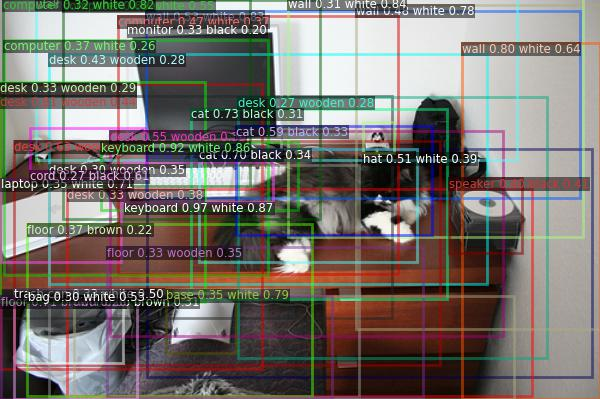

In [13]:
# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

#image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

### 모델 평가
그림에 대한 질문에 대한 예측들을 살펴봤을 때 상시적인 답변을 하는 것을 볼 수 있다.

In [14]:
#Very important that the boxes are normalized
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

In [15]:
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

In [16]:
test_question = ["What is near the disk?"]

inputs = lxmert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

In [17]:
print(inputs.input_ids)
print(inputs.attention_mask)

tensor([[ 101, 2054, 2003, 2379, 1996, 9785, 1029,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [18]:
lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")

In [19]:
output_vqa = lxmert_vqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_feats=features,
    visual_pos=normalized_boxes,
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

output_vqa

LxmertForQuestionAnsweringOutput(loss=None, question_answering_score=tensor([[-4.8011, -2.3278,  6.5088,  ..., -1.3233,  1.5725,  0.5884]],
       grad_fn=<AddmmBackward>), language_hidden_states=None, vision_hidden_states=None, language_attentions=None, vision_attentions=None, cross_encoder_attentions=None)

In [20]:
len(output_vqa["question_answering_score"][0])

3129

In [21]:
# get prediction
pred_vqa = output_vqa["question_answering_score"].argmax(-1)

pred_vqa

tensor([1770])

In [22]:
print("Question:", test_question)
print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['What is near the disk?']
prediction from LXMERT VQA: cat


In [23]:
test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
    "What is the color of the keyboard?",
]

for test_question in test_questions_for_url2:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['Where is the cat?']
prediction from LXMERT VQA: desk
Question: ['What is near the disk?']
prediction from LXMERT VQA: cat
Question: ['What is the color of the table?']
prediction from LXMERT VQA: brown
Question: ['What is the color of the cat?']
prediction from LXMERT VQA: black and white
Question: ['What is the shape of the monitor?']
prediction from LXMERT VQA: rectangle
Question: ['What is the color of the keyboard?']
prediction from LXMERT VQA: white


In [24]:
test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
    "What is the color of the keyboard?",
]

## STEP 2. GQA 데이터셋 버전 모델 테스트해 보기
이전 노드에서 소개했던 VQA를 위한 다양한 데이터셋 중에 GQA라는 것이 있었습니다. 이 데이터셋은 scene graph라는 것을 활용해서 object간 관계를 더욱 명확하게 학습할 수 있도록 한 것입니다.

지금까지 사용했던 모델은 VQA2 데이터셋을 활용해 학습시킨 모델이었습니다. Huggingface에서는 동일한 모델 구조를 활용해 GQA로 학습시킨 모델을 함께 제공하고 있습니다. 아래 정보를 활용해 위 STEP 1. 에서 테스트했던 이미지에 대해 동일하게 테스트해 봅시다.

즉, 같은 과정을 반복하되 모델과 데이터 셋만 바꿔서 진행을 한다.

In [25]:
GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"

lxmert_gqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")

In [26]:
# GQA answer definition
GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"
gqa_answers = utils.get_data(GQA_URL)
print(len(gqa_answers))
print(gqa_answers[:30])  #3129개의 단어사전 중 30개만 출력

1842
['cat food', 'elephant', 'gloves', 'football', 'dock', 'shops', 'water', 'light blue', 'chair', 'players', 'tourist', 'magnet', 'railroad', 'ski lift', 'mirror', 'leggings', 'hurdle', 'shuttle', 'wildflowers', 'flowers', 'cooking pot', 'pipe', 'swan', 'girl', 'celery', 'brown', 'ambulance', 'steps', 'power line', 'asphalt']


In [27]:
# 위 이미지의 URL
URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
image_preprocess = Preprocess(frcnn_cfg)

images, sizes, scales_yx = image_preprocess(URL)

loading configuration file cache


In [28]:
print(images)
print(sizes)

tensor([[[[  61.0199,   61.2689,   62.1015,  ...,   50.5607,   50.1444,
             50.0199],
          [  60.8955,   61.1445,   61.9771,  ...,   50.8094,   50.3931,
             50.2686],
          [  60.4793,   60.7282,   61.5609,  ...,   51.6420,   51.2256,
             51.1012],
          ...,
          [ -87.9801,  -88.0373,  -88.2285,  ...,   21.7716,   21.5466,
             21.4793],
          [ -87.9801,  -88.0891,  -88.4536,  ...,   21.9628,   21.9110,
             21.8955],
          [ -87.9801,  -88.1046,  -88.5209,  ...,   22.0199,   22.0199,
             22.0199]],

         [[  48.0535,   48.4269,   49.6759,  ...,   41.5943,   41.1780,
             41.0535],
          [  47.9291,   48.2871,   49.4843,  ...,   41.5943,   41.1780,
             41.0535],
          [  47.5129,   47.8190,   48.8429,  ...,   41.5943,   41.1780,
             41.0535],
          ...,
          [ -99.9465,  -99.9364,  -99.9026,  ...,   13.8052,   13.5802,
             13.5129],
          [ -99.94

In [29]:
test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
    "What is the color of the keyboard?",
]

In [30]:
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/aiffel-dj28/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [31]:
frcnn_cfg.max_detections  # object detection 모델이 검출할 최대 object 개수

36

In [32]:
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)

In [33]:
print(output_dict.get("boxes"))
print('-------------')
print(output_dict.get("boxes").shape)

tensor([[[1.0372e+02, 1.3613e+02, 2.2735e+02, 1.6974e+02],
         [8.4005e+01, 1.1941e+02, 2.4814e+02, 1.7585e+02],
         [0.0000e+00, 8.1354e+01, 3.2642e+02, 2.6568e+02],
         [3.8475e+02, 3.7221e+01, 4.9974e+02, 3.3300e+02],
         [2.9875e+01, 0.0000e+00, 4.3054e+02, 1.3465e+02],
         [1.5929e+02, 9.1682e+01, 3.7275e+02, 2.4955e+02],
         [6.7672e-01, 2.4750e+02, 2.7701e+02, 3.3300e+02],
         [1.6578e+02, 1.2526e+02, 3.4723e+02, 2.1946e+02],
         [0.0000e+00, 7.1275e+01, 2.1836e+02, 3.0790e+02],
         [5.2669e+01, 1.7062e+00, 2.6646e+02, 1.8314e+02],
         [6.1805e+01, 2.4761e+02, 4.2838e+02, 3.3299e+02],
         [1.2076e+01, 1.1892e+02, 3.6657e+02, 3.0462e+02],
         [1.9641e+02, 1.0624e+02, 3.5971e+02, 1.9710e+02],
         [9.1356e+01, 1.1064e+02, 4.1889e+02, 2.8040e+02],
         [1.2139e+02, 1.0626e+01, 4.8306e+02, 1.6577e+02],
         [3.0271e+02, 1.0307e+02, 3.2805e+02, 1.2879e+02],
         [2.9658e+02, 5.5949e+00, 4.9991e+02, 2.7482e+02

In [34]:
print(output_dict.get("roi_features"))
print('-------------')
print(output_dict.get("roi_features").shape)

tensor([[[2.4822e-03, 2.3580e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 3.3088e+00],
         [2.6639e-01, 1.0124e+00, 0.0000e+00,  ..., 9.0339e-04,
          1.5285e-02, 3.0090e+00],
         [6.0975e-01, 0.0000e+00, 0.0000e+00,  ..., 1.0956e-01,
          2.5223e-01, 1.7357e+00],
         ...,
         [7.9118e-01, 2.3213e-01, 0.0000e+00,  ..., 2.2883e-02,
          7.2807e-03, 6.4609e-01],
         [0.0000e+00, 1.4173e+00, 0.0000e+00,  ..., 0.0000e+00,
          2.0937e+00, 1.9630e+00],
         [1.0801e+00, 8.3446e-01, 0.0000e+00,  ..., 1.2504e-02,
          3.0912e-01, 6.6703e-01]]])
-------------
torch.Size([1, 36, 2048])


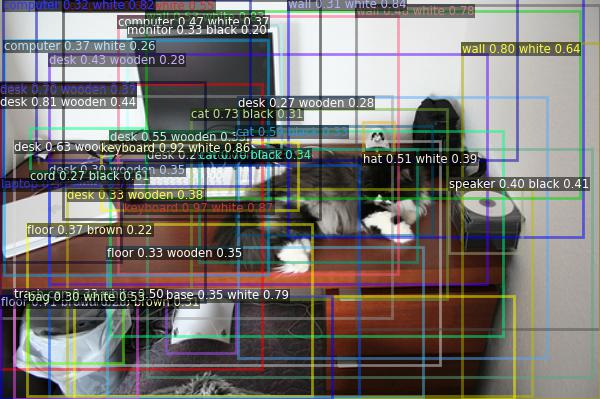

In [35]:
# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

#image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

In [36]:
#Very important that the boxes are normalized
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

In [37]:
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

In [38]:
test_question = ["What is near the disk?"]

inputs = lxmert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

In [39]:
print(inputs.input_ids)
print(inputs.attention_mask)

tensor([[ 101, 2054, 2003, 2379, 1996, 9785, 1029,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [40]:
lxmert_gqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")

In [41]:
output_gqa = lxmert_gqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_feats=features,
    visual_pos=normalized_boxes,
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

output_gqa

LxmertForQuestionAnsweringOutput(loss=None, question_answering_score=tensor([[ 1.6444, -2.7622,  0.1815,  ..., -0.5570, -0.1211,  2.0017]],
       grad_fn=<AddmmBackward>), language_hidden_states=None, vision_hidden_states=None, language_attentions=None, vision_attentions=None, cross_encoder_attentions=None)

In [42]:
len(output_gqa["question_answering_score"][0])

1842

In [43]:
# get prediction
pred_gqa = output_gqa["question_answering_score"].argmax(-1)

pred_gqa

tensor([621])

In [44]:
print("Question:", test_question)
print("prediction from LXMERT GQA:", gqa_answers[pred_gqa])

Question: ['What is near the disk?']
prediction from LXMERT GQA: can


In [45]:
test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
    "What is the color of the keyboard?",
]

for test_question in test_questions_for_url2:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_gqa = lxmert_gqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_gqa = output_gqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", gqa_answers[pred_gqa])

Question: ['Where is the cat?']
prediction from LXMERT VQA: desk
Question: ['What is near the disk?']
prediction from LXMERT VQA: can
Question: ['What is the color of the table?']
prediction from LXMERT VQA: brown
Question: ['What is the color of the cat?']
prediction from LXMERT VQA: black
Question: ['What is the shape of the monitor?']
prediction from LXMERT VQA: square
Question: ['What is the color of the keyboard?']
prediction from LXMERT VQA: white


## STEP 3. 내가 선택한 이미지로 VQA/GQA 버전 비교해 보기
    이번에는 여러분들이 임의로 이미지를 하나 골라 봅시다.
    이미지에 대해 3~5가지 정도 영어로 질문을 작성해 봅시다.
    STEP 1, 2에서 수행했던 내용을 본인이 고른 이미지에 대해 동일하게 수행하고, 결과를 비교해 봅시다.


아래에 준비된 이미지와 영어로 된 질문으로 수행을 한다.

In [46]:
img = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/images/input.jpg"

q_list = [
    "Where is this scene?",
    "what is the man riding?",
    "What is the man wearing?",
    "What is the color of the horse?"
]

### 파이프라인
위에서 한 작업과 동일하기 때문에 파이프라인으로 만들어서 실험을 한다.

In [47]:
def qa_pipeline(img_url, q_list, v=1):
    OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
    objids = utils.get_data(OBJ_URL)
    
    ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
    attrids = utils.get_data(ATTR_URL)
    
    if v==1: 
        QA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
    else: 
        QA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"

    qa_answers = utils.get_data(QA_URL)
    
    frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
    image_preprocess = Preprocess(frcnn_cfg)

    images, sizes, scales_yx = image_preprocess(img_url)
    
    frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
    frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)
    
    output_dict = frcnn(
        images, 
        sizes, 
        scales_yx=scales_yx, 
        padding="max_detections",
        max_detections=frcnn_cfg.max_detections,
        return_tensors="pt"
    )
    # for visualizing output
    def showarray(a, fmt='jpeg'):
        a = np.uint8(np.clip(a, 0, 255))
        f = io.BytesIO()
        PIL.Image.fromarray(a).save(f, fmt)
        display(Image(data=f.getvalue()))

    #image viz
    frcnn_visualizer = SingleImageViz(img_url, id2obj=objids, id2attr=attrids)

    frcnn_visualizer.draw_boxes(
        output_dict.get("boxes"),
        output_dict.pop("obj_ids"),
        output_dict.pop("obj_probs"),
        output_dict.pop("attr_ids"),
        output_dict.pop("attr_probs"),
    )
    showarray(frcnn_visualizer._get_buffer())
    
    normalized_boxes = output_dict.get("normalized_boxes")
    features = output_dict.get("roi_features")
    
    lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")
    
    if v==1: 
        lxmert_qa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")
    else: 
        lxmert_qa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")
    
    for test_question in q_list:
        # run lxmert
        test_question = [test_question]

        inputs = lxmert_tokenizer(
            test_question,
            padding="max_length",
            max_length=20,
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        # run lxmert(s)
        output_qa = lxmert_qa(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            visual_feats=features,
            visual_pos=normalized_boxes,
            token_type_ids=inputs.token_type_ids,
            output_attentions=False,
        )
        # get prediction
        pred_qa = output_qa["question_answering_score"].argmax(-1)
        print("Question:", test_question)
        print("prediction from LXMERT QA:", qa_answers[pred_qa])

### VQA
답변을 보면 그럴듯한 것을 알 수 있다.

loading configuration file cache
loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/aiffel-dj28/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


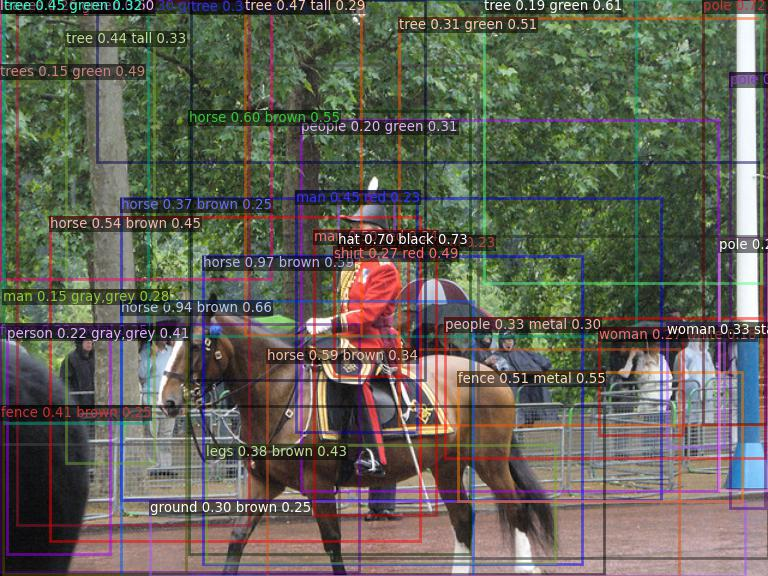

Question: ['Where is this scene?']
prediction from LXMERT QA: outdoors
Question: ['what is the man riding?']
prediction from LXMERT QA: horse
Question: ['What is the man wearing?']
prediction from LXMERT QA: suit
Question: ['What is the color of the horse?']
prediction from LXMERT QA: brown


In [48]:
qa_pipeline(img,q_list)

### GQA
답변을 보면 그럴듯한 것을 알 수 있다.

loading configuration file cache
loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/aiffel-dj28/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


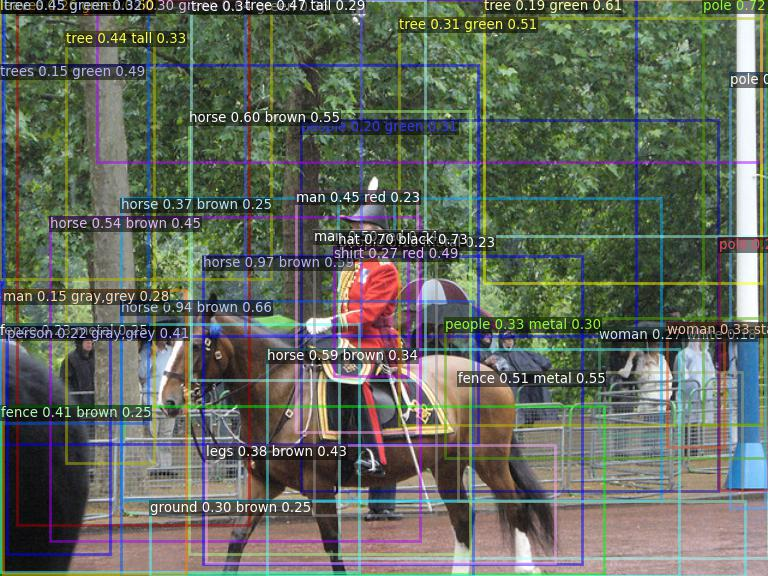

Question: ['Where is this scene?']
prediction from LXMERT QA: stadium
Question: ['what is the man riding?']
prediction from LXMERT QA: horse
Question: ['What is the man wearing?']
prediction from LXMERT QA: hat
Question: ['What is the color of the horse?']
prediction from LXMERT QA: brown


In [49]:
qa_pipeline(img,q_list,0)

### 비교
2개의 모델 간의 차이는 명확한 답변에서는 없지만 여러 개의 답이 나올 수 있는 경우 서로 관점이 다르게 나온 것을 확인할 수 있다.

## 회고 및 루브릭 평가

### 루브릭 평가 항목
1. LXMERT 모델을 활용해 새로운 이미지에 대한 VQA 작업을 진행하였다.
	(이미지 bounding box 시각화 및 question에 대한 answer 출력이 정상적으로 진행되었다.)
2. GQA 버전의 LXMERT 모델을 활용해 VQA 작업을 진행하였다.
	(GQA 버전 모델을 활용하여 question에 대한 answer 출력이 정상적으로 진행되었다.)
3. VQA, GQA 버전의 성능을 체계적으로 비교분석하였다.
	(자신이 선택한 다양한 이미지에 대해 두 모델의 답안이 어떻게 달라지는지 비교분석 결과를 제출하였다.)

### 평가 항목에 대한 수행
1. LXMERT 모델을 활용해 새로운 이미지에 대한 VQA 작업을 진행하였다.
2. GQA 버전의 LXMERT 모델을 활용해 VQA 작업을 진행하였다.
3. VQA, GQA 버전의 성능을 체계적으로 비교분석하였다.

### 회고

노션에 공지된 꼭 포함이 되어야 할 점
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

---
- **어려웠던 점**   
특별히 없었다.

---
- **알아낸 점**    
hugging face를 이용하여 lxmert를 구현하는 방법에 대해서 알 수 있었다.


- **모호한 점**    
단순히 프레임워크를 사용하여 구현을 하였기 때문에 내부적으로 어떻게 구현했는지에 대해서는 알 수 없었다.

---
- **시도한 것들**   
vqa와 gqa에 대하여 실험을 하였다.

---
- **루브릭 평가 관련 지표**   
제 예상에는 모두 달성되었다고 생각한다. 그 이유는 위에 있는 **평가 항목에 대한 수행**에 나와있다.  
- **자기 다짐** 및 **나의 생각들**  
이전 노드에 이어서 프레임 워크를 사용하는 방법을 배울 수 있었다.